# Lesson - Machine Learning XI: Decision Trees and Random Forests

## Sec-I: Introduction to Decision Trees
Decision trees are a powerful and popular machine learning technique. The basic concept is very similar to trees you may have seen commonly used to aid decision-making. Here's an example:

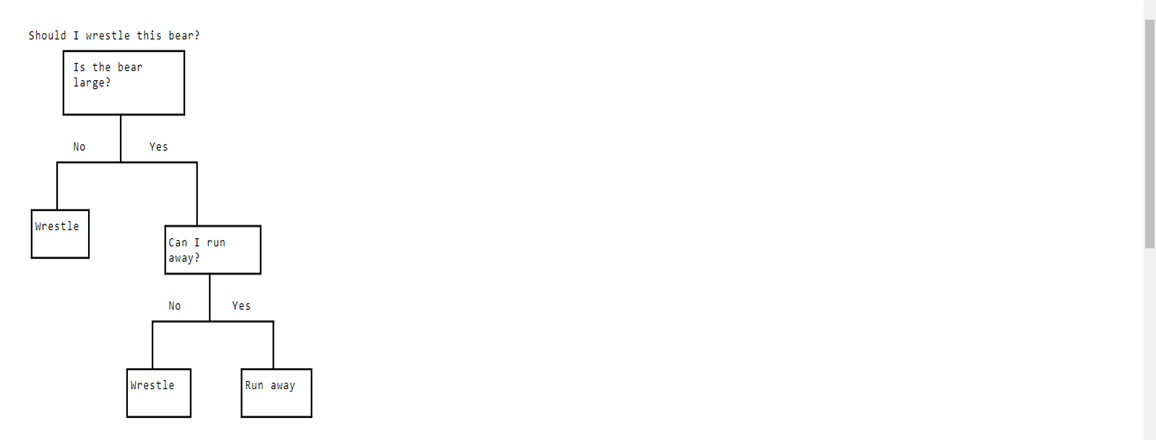

In the diagram above, we're deciding whether we should wrestle a bear that's in front of us. We're using various criteria to make our final decision, including the size of the bear, and whether escape is possible. Let's say we had a data set of people who survived bear encounters and the actions they took:
```
Bear name    Size    Escape possible?    Action
Yogi         Small   No                  Wrestle
Winnie       Small   Yes                 Wrestle
Baloo        Large   Yes                 Run away
Gentle Ben   Large   No                  Wrestle
```
If we wanted to optimize our chances of surviving a bear encounter, we could construct a decision tree to tell us what action to take.

As our data set gets larger though, this becomes less and less practical. What if we had 10000 rows and 10 variables? Would you want to look through all of the possibilities to construct a tree?

This is where the decision tree machine learning algorithm can help. It enables us to automatically construct a decision tree that tells us what outcomes we should predict in certain situations.

The decision tree algorithm is a supervised learning algorithm -- we first construct the tree with historical data, and then use it to predict an outcome. One of the major advantages of decision trees is that they can pick up nonlinear interactions between variables in the data that linear regression can't. In our bear wrestling example, a decision tree can pick up on the fact that you should only wrestle large bears when escape is impossible, whereas a linear regression would have had to weight both factors in the absence of the other.

We can use trees for classification or regression problems. In this lesson, we'll walk through the building blocks of making a decision tree automatically.

### Dataset

We'll be looking at individual income in the United States. The data is from the 1994 census, and contains information on an individual's marital status, age, type of work, and more. The target column, or what we want to predict, is whether individuals make less than or equal to 50k a year, or more than 50k a year.

We can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Adult).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Setting pandas display options for large data
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150

In [2]:
# Read in dataset
# Set index_col to False to avoid pandas thinking that the first column is row indexes (it's age)
income = pd.read_csv("income.csv", index_col=False)
print(income.head(5))

   age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country high_income  
0          2174             0              40   United-States   

In [3]:
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  high_income     32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### Converting Categorical Variables
As we can see in our data, we have categorical variables such as `workclass` that have string values. Multiple individuals can share the same string value. The types of work include `State-gov`, `Self-emp-not-inc`, `Private`, and so on. Each of these strings is a label for a category. Another example of a column of categories is `sex`, where the options are `Male` and `Female`.

Before we get started with decision trees, we need to convert the categorical variables in our data set to numeric variables. This involves assigning a number to each category label, then converting all of the labels in a column to the corresponding numbers.

One strategy is to convert the columns to a `categorical` type. Under this approach, pandas will display the labels as strings, but internally store them as numbers so we can do computations with them. The numbers aren't always compatible with other libraries like Scikit-learn, though, so it's easier to just do the conversion to numeric upfront.

We can use the [`pandas.Categorical()` class]( from pandas to perform the conversion to numbers.

Below, we wil convert the categorical columns in dataframe `income` (`workclass`, `education`, `marital_status`, `occupation`, `relationship`, `race`, `sex`, `native_country`, and `high_income`) to numeric columns.

In [4]:
cat_cols = list(income.select_dtypes(include = 'object').columns)
cat_cols

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country',
 'high_income']

For some reason `for` loop is not working for this class
```
# for col_name in cat_cols:
#     col = pd.Categorical(income[col_name])
# income[col_name] = col.codes
```
So, we will set the columns manually

In [5]:

col = pd.Categorical(income["workclass"])
income["workclass"] = col.codes
col = pd.Categorical(income["education"])
income["education"] = col.codes
col = pd.Categorical(income["marital_status"])
income["marital_status"] = col.codes
col = pd.Categorical(income["occupation"])
income["occupation"] = col.codes
col = pd.Categorical(income["relationship"])
income["relationship"] = col.codes
col = pd.Categorical(income["race"])
income["race"] = col.codes
col = pd.Categorical(income["sex"])
income["sex"] = col.codes
col = pd.Categorical(income["native_country"])
income["native_country"] = col.codes
col = pd.Categorical(income["high_income"])
income["high_income"] = col.codes


In [6]:
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


In [7]:
income['marital_status'].value_counts().sort_index()

0     4443
1       23
2    14976
3      418
4    10683
5     1025
6      993
Name: marital_status, dtype: int64

### Splitting the Data
A decision tree is made up of a series of nodes and branches. A node is where we split the data based on a variable, and a branch is one side of the split. Here's an example:
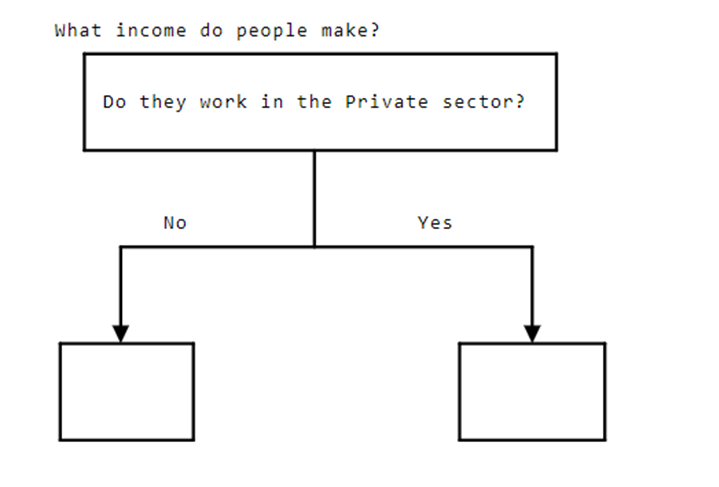

In the diagram above, the node splits the data into two branches, `No` and `Yes`, based on whether the individual works in the private sector (the workclass column). We've mapped the value Private in the workclass column to the numeric code `4` (we can check this by comparing the values in the workclass column that used to have the label Private with the current values to see where they line up). So the `No` branch corresponds to workclass `!= 4`, and the `Yes` branch corresponds to workclass `== 4`.

This is exactly how a decision tree works -- we keep splitting the data based on variables. As we do this, the tree accumulates more levels. The tree we made above is two levels deep because it has one split, and two "levels" of nodes.



The tree below is three levels deep.
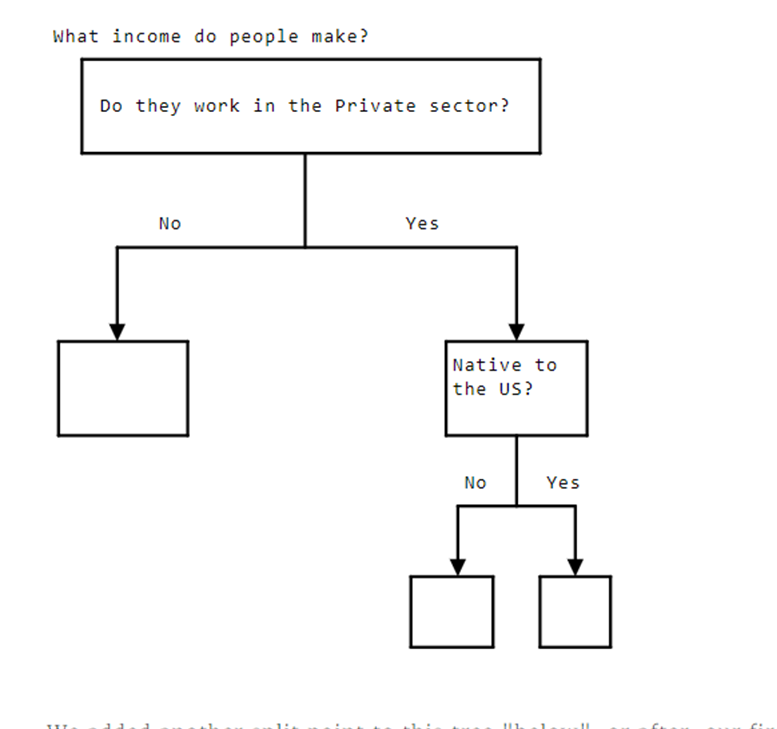
We added another split point to this tree "below", or after, our first split point. This made the tree three levels deep.

We can think of rows of data flowing through a decision tree. Next, we'll split the data set into two portions based on whether the individual works in the private sector or not.

Split income into two parts based on the value of the `workclass` column.

- `private_incomes` should contain all rows where `workclass` is `4`.
- `public_incomes` should contain all rows where `workclass` is `not 4`.

In [8]:
private_incomes = income[income['workclass'] == 4]
private_incomes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22696 entries, 2 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             22696 non-null  int64
 1   workclass       22696 non-null  int8 
 2   fnlwgt          22696 non-null  int64
 3   education       22696 non-null  int8 
 4   education_num   22696 non-null  int64
 5   marital_status  22696 non-null  int8 
 6   occupation      22696 non-null  int8 
 7   relationship    22696 non-null  int8 
 8   race            22696 non-null  int8 
 9   sex             22696 non-null  int8 
 10  capital_gain    22696 non-null  int64
 11  capital_loss    22696 non-null  int64
 12  hours_per_week  22696 non-null  int64
 13  native_country  22696 non-null  int8 
 14  high_income     22696 non-null  int8 
dtypes: int64(6), int8(9)
memory usage: 1.4 MB


In [9]:
public_incomes = income[income['workclass'] != 4]
public_incomes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9865 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             9865 non-null   int64
 1   workclass       9865 non-null   int8 
 2   fnlwgt          9865 non-null   int64
 3   education       9865 non-null   int8 
 4   education_num   9865 non-null   int64
 5   marital_status  9865 non-null   int8 
 6   occupation      9865 non-null   int8 
 7   relationship    9865 non-null   int8 
 8   race            9865 non-null   int8 
 9   sex             9865 non-null   int8 
 10  capital_gain    9865 non-null   int64
 11  capital_loss    9865 non-null   int64
 12  hours_per_week  9865 non-null   int64
 13  native_country  9865 non-null   int8 
 14  high_income     9865 non-null   int8 
dtypes: int64(6), int8(9)
memory usage: 626.2 KB


### Decision Trees as Flows of Data
When we performed the split, `9865` rows went to the left, where workclass does not equal `4`, and `22696` rows went to the right, where workclass equals `4`.

It's useful to think of a decision tree as a flow of rows of data. When we make a split, some rows will go to the right, and some will go to the left. As we build the tree deeper and deeper, each node will "receive" fewer and fewer rows.

Here's a look at the splits, and the number of rows that will exist at each node:

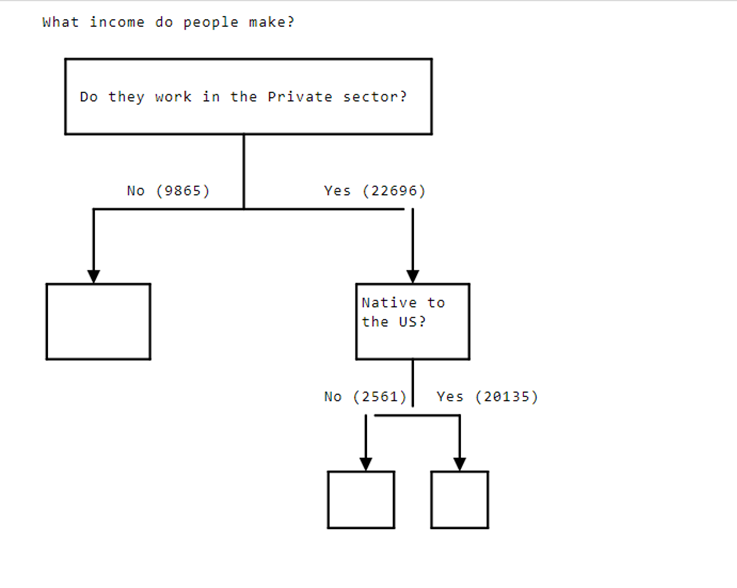

### Splitting Data to Make Predictions

The nodes at the bottom of the tree, where we decide to stop splitting, are called terminal nodes, or leaves. When we do our splits, we aren't doing them randomly; we have an objective. Our goal is to ensure that we can make a prediction on future data. In order to do this, all rows in each leaf must have only one value for our target column.

We're trying to predict the `high_income column`.
If `high_income` is `1`, it means that the person has an income higher than `50k` a year.
If `high_income` is `0`, it means that they have an income less than or equal to `50k` a year.

After constructing a tree using the income data, we'll want to make predictions. In order to do this, we'll take a new row and feed it through our decision tree.

First, we check whether the person works in the private sector. If they do, we'll check to see whether they're native to the US, and so on.

Eventually, we'll reach a leaf. The leaf will tell us what value we should predict for `high_income`.

In order to be able to make this prediction, all of the rows in a leaf should only have a single value for `high_income`. This means that leaves can't have both `0` and `1` values in the `high_income` column. Each leaf can only have rows with the same values for our target column. If this isn't the case, we won't be able to make effective predictions.

We'll need to continue splitting nodes until we get to a point where all of the rows in a node have the same value for `high_income`.

### Dataset Entropy

Now that we have a high-level view of how decision trees work, let's explore the details and learn how to perform the splits.

We'll use a specific measure to figure out which variables we should split nodes on. Post-split, we'll have two data sets, each containing the rows from one branch of the split.

Because we're trying to reach the leaves having only `1s` or only `0s` in `high_income`, each split will need to get us closer to that goal.

When we split, we'll try to separate as many `0s` from 1s in the `high_income` column as we can. In order to do this, we need a metric for how "together" the different values in the` high_income` column are.

Data scientists commonly use a metric called `entropy` for this purpose. `Entropy` refers to disorder. The more "mixed together" `1s` and `0s` are, the higher the `entropy`. A data set consisting entirely of 1s in the` high_income` column would have low `entropy`.
Entropy, which is not to be confused with entropy from physics, comes from information theory. Information theory is based on probability and statistics, and deals with the transmission, processing, utilization, and extraction of information. A key concept in information theory is the notion of a bit of information. One bit of information is one unit of information.

We can represent a bit of information as a binary number because it either has the value `1` or `0`. Suppose there's an equal probability of tomorrow being sunny (`1`) or not sunny (`0`). If I tell you that it will be sunny, I've given you one bit of information.

We can also think of entropy in terms of information. If we flip a coin where both sides are heads, we know upfront that the result will be heads. We gain no new information by flipping the coin, so entropy is 0. On the other hand, if the coin has a heads side and a tails side, there's a 50% probability that it will land on either. Thus, flipping the coin gives us one bit of information -- which side the coin landed on.

Entropy can be much more complex, especially when we get to cases with more than two possible outcomes, or differential probabilities. The formula for entropy is:
$$-\sum_{i=1}^{c} {\mathrm{P}(x_i) \log_b \mathrm{P}(x_i)}$$

We iterate through each unique value in a single column (in this case, `high_income`), and assign it to `i`. We then compute the probability of that value occurring in the data (`P(xi)`). Next we do some multiplication, and sum all of the values together. `b` is the base of the logarithm. We commonly use the value `2` for this, but we can also set it to `10` or another value.

Let's say we have this data:
```
age    high_income
25     1
50     1
30     0
50     0
80     1
```
We could compute its entropy like this:
$$
\begin{align}
-\sum_{i=1}^{c} {\mathrm{P}(x_i) \log_b \mathrm{P}(x_i)} \nonumber \\
-((2/5 * \log_2 2/5) + (3/5 * \log_2 3/5)) \nonumber \\ 
-(-0.5287712379549449 + -0.44217935649972373)\nonumber \\
.97 \nonumber \\
\end{align}
$$

We get less than one "bit" of information -- only `.97` -- because there are slightly more 1s in the sample data than 0s. This means that if we were predicting a new value, we could guess that the answer is `1` and be right more often than wrong (because there's a `.6` probability of the answer being `1`). Due to this prior knowledge, we gain less than a full "bit" of information when we observe a new value.


In [10]:
import math
# We'll do the same calculation we did above, but in Python
# Passing in 2 as the second parameter to math.log will take a base 2 log
entropy = -(2/5 * math.log(2/5, 2) + 3/5 * math.log(3/5, 2))
print(entropy)

0.9709505944546686


Below, we wil compute the entropy of the` high_income` column in the income dataframe, and assign the result to `income_entropy`.

In [11]:
prob_0 = income[income["high_income"] == 0].shape[0] / income.shape[0]
prob_1 = income[income["high_income"] == 1].shape[0] / income.shape[0]
income_entropy = -(prob_0 * math.log(prob_0, 2) + prob_1 * math.log(prob_1, 2))
income_entropy

0.7963839552022132

### Information Gain

We'll need a way to go from computing entropy to figuring out which variable to split on. We can do this using information gain, which tells us which split will reduce entropy the most.

Here's the formula for information gain:
$$IG(T,A) = Entropy(T)-\sum_{v\in A}\frac{|T_{v}|}{|T|} \cdot Entropy(T_{v})$$

We're computing information gain (IG) for a given target variable (T), as well as a given variable we want to split on (A).
To compute it, we first calculate the entropy for T. Then, for each unique value v in the variable A, we compute the number of rows in which A takes on the value v, and divide it by the total number of rows. Next, we multiply the results by the entropy of the rows where A is v. We add all of these subset entropies together, then subtract from the overall entropy to get information gain.

Here's an alternate explanation. We're finding the entropy of each set post-split, weighting it by the number of items in each split, then subtracting from the current entropy. If the result is positive, we've lowered entropy with our split. The higher the result is, the more we've lowered entropy.

One strategy for constructing trees is to create as many branches at each node as there are unique values for the variable we're splitting on. So if the variable has three or four values, we'd end up with three or four branches. This approach usually involves more complexity than it's worth and doesn't improve prediction accuracy, but it's worth knowing about.

To simplify the calculation of information gain and make splits simpler, we won't do it for each unique value. We'll find the median for the variable we're splitting on instead. Any rows where the value of the variable is below the median will go to the left branch, and the rest of the rows will go to the right branch. To compute information gain, we'll only have to compute entropies for two subsets.

Here's an example that uses the same data set we worked with earlier:
```
age    high_income
25     1
50     1
30     0
50     0
80     1
```
Let's say we wanted to split this data set based on age. First, we calculate the median age, which is 50. Then, we assign any row with a value less than or equal to the median age the value `0` (in a new column named split_age), and the other rows `1`.

```
age    high_income    split_age
25     1              0
50     1              0
30     0              0
50     0              0
80     1              1
```
Now, we compute IG

$$
\begin{align}
IG(T,A) = Entropy(T)-\sum_{v\in A}\frac{|T_{v}|}{|T|} \cdot Entropy(T_{v}) \nonumber \\
.97 - (((4/5) * -(2/4 * log_{2} 2/4 + 2/4 * log_{2} 2/4 )) + -(1/5 *  (0 * log_{2} 0 + 1 * log_{2} 1 ))) \nonumber \\
 .97 - ((4/5) * -(-.5 + -.5)) + (1/5 *  -(0 + 1 * 0 )) \nonumber \\
.97 - (4/5) \nonumber \\
.17 \nonumber \\
\end{align}
$$

We end up with `0.17`, which means that we gain `0.17` bits of information by splitting our data set on the age variable.

Recall that our target variable is `high_income` so we'll represent the column using `T`, and the `split_age` is the column we're splitting so we'll represent that column using `A`.

Since we're splitting on the `age` column, we'll need to calculate the probabilities for each unique value in the `split_age` column to get the `Entropy(Tv)`. Since our unique values in the split_age column are `0` and `1`, let's start by considering the rows where the value in the split_age column is `0` (note that these rows correspond to the split where the median age is less than or equal to 50, the median age). Three of the values in the `high_income` column have a value of `1`, while the other two values have a value of `0`. Let's now consider the other split, where the value in `split_age` is `1` — this is the split corresponding to those rows where the median age is greater than 50, the median age. We only have one row with a value of `1` for the `high_income` column.

In [12]:
# Write a function to calculate entropy of a column and then compute information gain from it

def calc_entropy(column):
    """
    Calculate entropy given a pandas series, list, or numpy array.
    """
    # Compute the counts of each unique value in the column
    counts = np.bincount(column)
    # Divide by the total column length to get a probability
    probabilities = counts / len(column)
    
    # Initialize the entropy to 0
    entropy = 0
    # Loop through the probabilities, and add each one to the total entropy
    for prob in probabilities:
        if prob > 0:
            entropy += prob * math.log(prob, 2)
    
    return -entropy

# Verify that our function matches our answer from earlier
entropy = calc_entropy([1,1,0,0,1])
print(entropy)

information_gain = entropy - ((.8 * calc_entropy([1,1,0,0])) + (.2 * calc_entropy([1])))
print(information_gain)

0.9709505944546686
0.17095059445466854


Below, we will:
Compute the information gain for splitting on the `age` column of `income`.

- First, compute the median of `age`.
Then, assign anything less than or equal to the median to the left branch, and anything greater than the median to the right branch.
Compute the information gain and assign it to age_information_gain.

In [13]:
income_entropy = calc_entropy(income["high_income"])

median_age = income["age"].median()

left_split = income[income["age"] <= median_age]
right_split = income[income["age"] > median_age]

age_information_gain = income_entropy - ((left_split.shape[0] / income.shape[0]) * calc_entropy(left_split["high_income"]) 
                                         + ((right_split.shape[0] / income.shape[0]) * calc_entropy(right_split["high_income"])))
age_information_gain

0.047028661304691965

### Finding the Best Split
Now that we know how to compute information gain, we can determine the best variable to split a node on. When we start our tree, we want to make an initial split. We'll find the variable to split on by calculating which split would have the highest information gain.
Below, we will:

Create a list called information_gains.

- It should contain, in order, the information gain from splitting on these columns: `age`, `workclass`, `education_num`, `marital_status`, `occupation`, `relationship`, `race`, `sex`, `hours_per_week`, `native_country`.
- Find the highest value in the `information_gains` list, and assign the corresponding column name to `highest_gain`.



In [14]:
def calc_information_gain(data, split_name, target_name):
    """
    Calculate information gain given a data set, column to split on, and target
    """
    # Calculate the original entropy
    original_entropy = calc_entropy(data[target_name])
    
    # Find the median of the column we're splitting
    column = data[split_name]
    median = column.median()
    
    # Make two subsets of the data, based on the median
    left_split = data[column <= median]
    right_split = data[column > median]
    
    # Loop through the splits and calculate the subset entropies
    to_subtract = 0
    for subset in [left_split, right_split]:
        prob = (subset.shape[0] / data.shape[0]) 
        to_subtract += prob * calc_entropy(subset[target_name])
    
    # Return information gain
    return original_entropy - to_subtract

# Verify that our answer is the same as on the last screen
print(calc_information_gain(income, "age", "high_income"))




0.047028661304691965


In [15]:
columns = ["age", "workclass", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "hours_per_week", "native_country"]
information_gains = []
# Loop through and compute information gains
for col in columns:
    information_gain = calc_information_gain(income, col, "high_income")
    information_gains.append(information_gain)

# Find the name of the column with the highest gain
highest_gain_index = information_gains.index(max(information_gains))
highest_gain = columns[highest_gain_index]
highest_gain

'marital_status'

### Build the Whole Tree
Now we know how to make a single split. To construct an entire tree, we'll need to continue creating splits until the leaves only have a single class.

Here's an example of what this looks like:

```
age    high_income
25     1
50     1
30     0
50     0
80     1
```

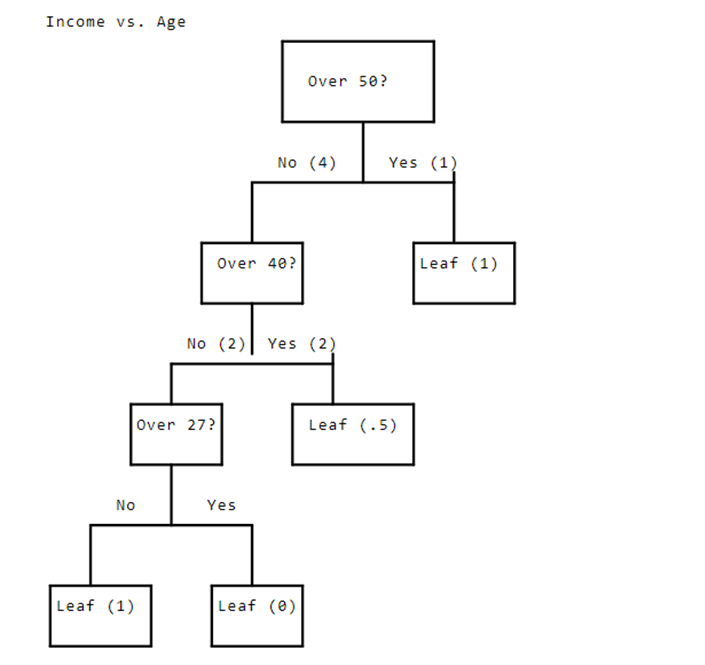

As we can see, we split the data all the way down the tree to the leaves. This example is different, because we only have a single variable to split with. This results in one leaf where both rows have an age of 50, so we can't split. One has a high_income of 1, however, and the other has a high_income of 0. That means we'd usually be able to split on another variable, but that's not possible in this case. Instead, we predict .5 for any rows that end up at this leaf.

In order to construct a tree like this, we'll need to be able to split each node multiple times.

So far, we've been following the [`ID3 algorithm`](https://en.wikipedia.org/wiki/ID3_algorithm) to construct decision trees. There are other algorithms like [`CART`](https://dq-content.s3.amazonaws.com/89/TREE-CART.pdf) that use different measures for the split criterion.

## Sec-II: Building a Decision Tree


### ID-3 Algorithm
Above, we discussed the basics of decision trees, including entropy and information gain. We will now build on those concepts to construct a full decision tree in Python and use it to make predictions. We'll use the `ID3` Algorithm for constructing decision trees to accomplish this. This algorithm involves [recursion](https://en.wikipedia.org/wiki/Recursion_(computer_science)) and an understanding of time complexity. In general, recursion is the process of splitting a large problem into smaller chunks. Recursive functions will call themselves, then combine the results into a final output. Building a tree is a perfect use case for recursive algorithms. At each node, we'll call a recursive function that will split the data into two branches. Each branch will lead to a node, and the function will call itself to build the tree out.

Pseudocode version of the full `ID3` Algorithm is given below. Pseudocode is a plain-text outline of a piece of code that explains how it works. Exploring the pseudocode for an algorithm is a good way to understand it better before trying to code it.

```
def id3(data, target, columns)
    1 Create a node for the tree
    2 If all values of the target attribute are 1, Return the node, with label = 1
    3 If all values of the target attribute are 0, Return the node, with label = 0
    4 Using information gain, find A, the column that splits the data best
    5 Find the median value in column A
    6 Split column A into values below or equal to the median (0), and values above the median (1)
    7 For each possible value (0 or 1), vi, of A,
    8    Add a new tree branch below Root that corresponds to rows of data where A = vi
    9    Let Examples(vi) be the subset of examples that have the value vi for A
   10    Below this new branch add the subtree id3(data[A==vi], target, columns)
   11 Return Root
   ```
   
 A minor modification to the algorithm has been made so that it only creates two branches from each node. This will simplify the process of constructing the tree, and make it easier to demonstrate the principles it involves.

The recursive nature of the algorithm comes into play on line `10`. Every node in the tree will call the `id3()` function, and the final tree will be the result of all of these calls.


### Example of ID-3 Algorithm

We'll make ID3 easier to follow by walking through an example with a dummy data set. We want to predict `high_income` using `age` and `marital_status`. In the `marital_status` column, `0` means unmarried, `1` means married, and `2` means divorced.

```
high_income    age    marital_status
0              20     0
0              60     2
0              40     1
1              25     1
1              35     2
1              55     1
```
We start with our algorithm: There are both `0s` and `1s` in `high_income`, so we skip lines `2` and `3`. We jump to line `4`. We won't go through the information gain calculations here, but the column we split on is `age`

On line `5`, we find the median, which is `37.5`.
Per line `6`, we make everything less than or equal to the median `0`, and anything greater than the median `1`. Next, we start the loop on line `7`. 
Because we're going through the possible values for `A` in order, we hit the `0` values first. We make a branch going to the left for rows of data where `age <= 37.5`.
We reach line `10`, and call `id3()` on the new node at the end of that branch.
The following diagram illustrates this chain of events. We've numbered the nodes in the bottom right corner.

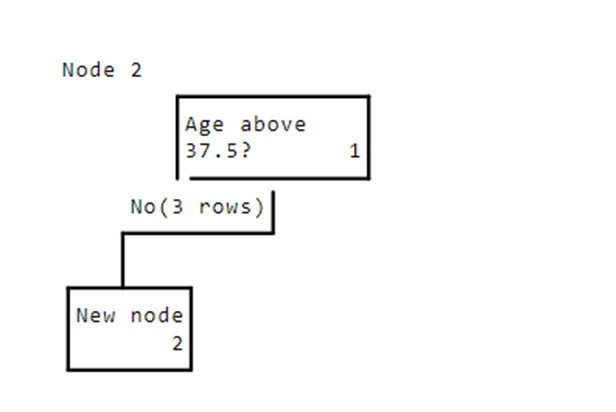

The new node has the following data:
```
high_income    age    marital_status
0              20     0
1              25     1
1              35     2
```
Because we recursively called the `id3()` function on line `10`, we start over at the top, with only the post-split data. We skip lines `2` and `3` again, and find another variable to split on. age is again the best split variable, with a median of `25`. We make a branch to the left where `age <= 25`.
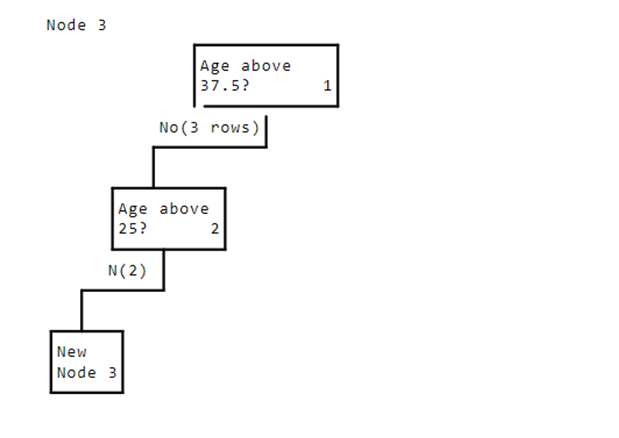

The new node has the following data:
```
high_income    age    marital_status
0              20     0
1              25     1
```


We'll hit line `10` again, and "pause" node `2` to start over in the `id3()` function. We find that the best column to split on is again `age`, and the median is `22.5`. We perform another split:

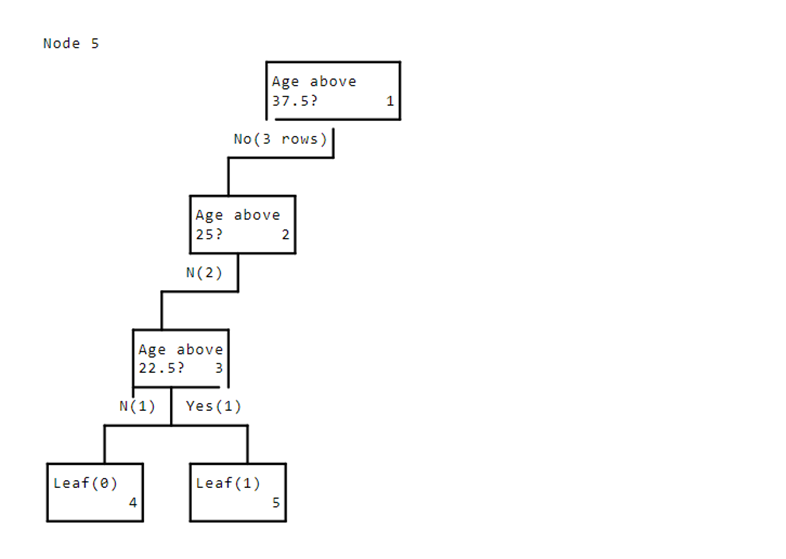
All of the values for `high_income` in node `4` are `0`. This means that line `3` applies, and we don't continue building the tree lower. This causes the `id3` function for node `4` to return. This "unpauses" the `id3()` function for node `3`, which then moves on to building the right side of the tree. Line `7` specifies that we're in a for loop. When the `id3()` algorithm for node `4` returns, node `3` goes to the next iteration in the for loop, which is the right branch. 

We're now on node `5`, which is the right side of the split we make from node `3`. This calls the `id3(`) function for node `5`, which stops at line `2` and returns. There's only one row in this split, and we end up with a leaf node again, where the label is `1`.

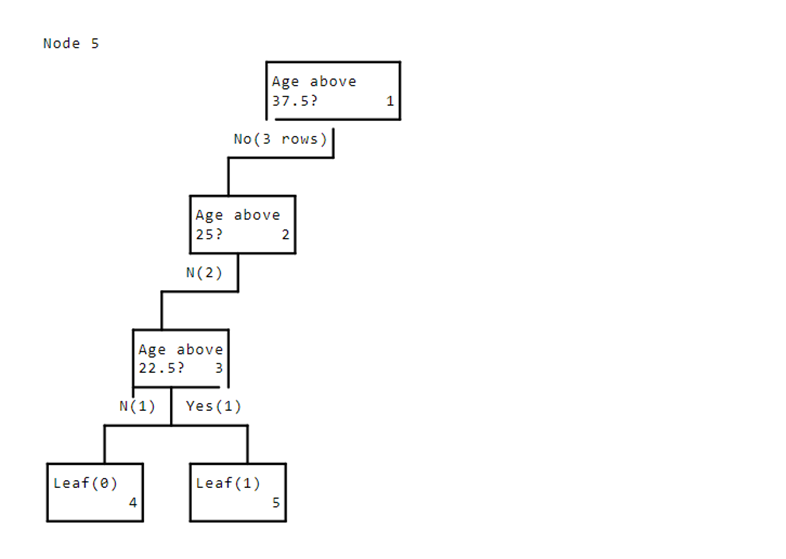

We're done with the entire loop for node `3`. We've constructed a left-hand subtree and a right-hand subtree, both of which end in terminal leaves having only one value for the target column. 

The `id3()` function for node `3` now hits line `11` and returns. This "unpauses" node `2`, where we construct the right split. There's only one row here -- the `35` year old. This again creates a leaf node, which will have the label `1`.
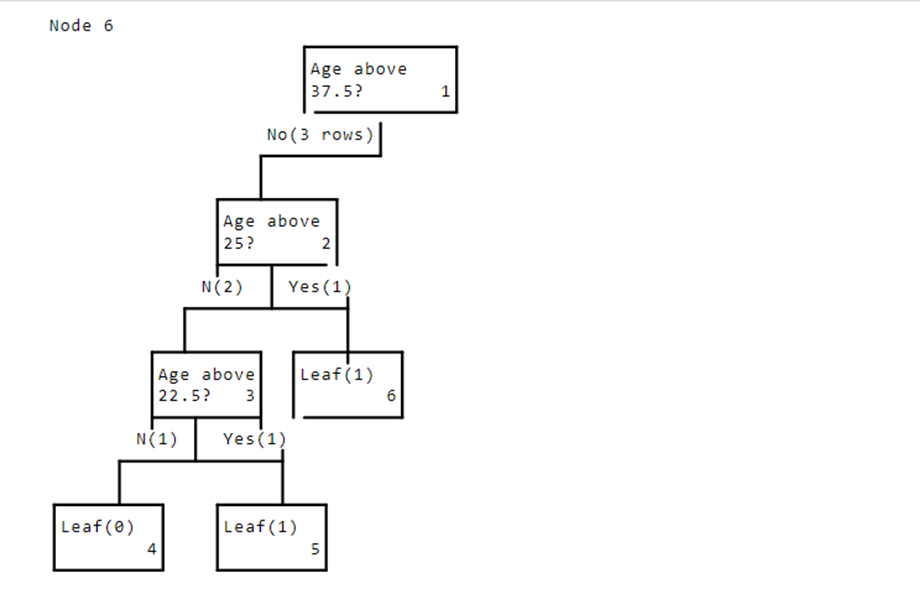

This causes node `2` to finish processing and return on line `11`. This causes node `1` to "unpause" and start building the right side of the tree.

We won't build out the entire right side of the tree right now. Instead, we'll dive into some code that will construct trees automatically.

### Determining the Best Column to Split on
We have already written functions to calculate entropy and information gain above as `calc_entropy()` and  `calc_information_gain()`.

Now we need a function that returns the name of the column we should use to split a data set. The function should take the name of the data set, the target column, and a list of columns we might want to split on as input.

Below, we will:
- Write a function named `find_best_column()` that returns the name of a column to split the data on. 
- Use `find_best_column()` to find the best column on which to split income.

- The target is the `high_income` column, and the potential columns to split with are in the list columns below.
- Assign the result to `income_split`.

In [16]:
def find_best_column(data, target_name, columns):
    '''data is a dataframe
    target_name is the name of the target variable
    columns is a list of potential columns to split on'''
    information_gains = []
    # Loop through and compute information gains
    for col in columns:
        information_gain = calc_information_gain(data, col, "high_income")
        information_gains.append(information_gain)

    # Find the name of the column with the highest gain
    highest_gain_index = information_gains.index(max(information_gains))
    highest_gain = columns[highest_gain_index]
    return highest_gain
    
# A list of columns to potentially split income with
columns = ["age", "workclass", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "hours_per_week", "native_country"]
income_split = find_best_column(income, "high_income", columns)
income_split

'marital_status'

### Creating a Simple Recursive Algorithm

We will make the full `id3()` function by creating a simpler algorithm that we can extend. Here's what that algorithm looks like in pseudocode:

```
def id3(data, target, columns)
    1 Create a node for the tree
    2 If all values of the target attribute are 1, add 1 to counter_1
    3 If all values of the target attribute are 0, add 1 to counter_0
    4 Using information gain, find A, the column that splits the data best
    5 Find the median value in column A
    6 Split A into values below or equal to the median (0), and values above the median (1)
    7 For each possible value (0 or 1), vi, of A,
    8    Add a new tree branch below Root that corresponds to rows of data where A = vi
    9    Let Examples(vi) be the subset of examples that have the value vi for A
   10    Below this new branch, add the subtree id3(data[A==vi], target, columns)
   11 Return Root
   ```
   This version is very similar to the algorithm above, but lines `2` and `3` are different. Rather than storing the entire tree (which is a bit complicated), we'll just tally how many leaves end up with the label `1`, and how many end up with the label `0`.
   
We'll replicate this algorithm in code, and apply it to the following dataset:
```
high_income    age    marital_status
0              20     0
0              60     2
0              40     1
1              25     1
1              35     2
1              55     1
```

Below, we will:

Write the `id3()` function:

- The function should append `1` to `label_1s` if the node should be a leaf, and only has `1s` for `high_income`.
- It should append `0` to `label_0s` if the node should be a leaf, and only has `0s` for `high_income`.

In [17]:
# We'll use lists to store our labels for nodes (when we find them)
# Lists can be accessed inside our recursive function, whereas integers can't.  
label_1s = []
label_0s = []

def id3(data, target, columns):
    # The pandas.unique method will return a list of all the unique values in a series
    unique_targets = pd.unique(data[target])
    
    if len(unique_targets) == 1:
        # Insert code here to append 1 to label_1s or 0 to label_0s, based on what we should label the node
        # See lines 2 and 3 in the algorithm
        if len(unique_targets) == 1:
            if 0 in unique_targets:
                label_0s.append(0)
            elif 1 in unique_targets:
                label_1s.append(1)
         # Returning here is critical -- if we don't, the recursive tree will never finish, and run forever
        return
          
    # Find the best column to split on in our data
    best_column = find_best_column(data, target, columns)
    # Find the median of the column
    column_median = data[best_column].median()
    
    # Create the two splits
    left_split = data[data[best_column] <= column_median]
    right_split = data[data[best_column] > column_median]
    
    # Loop through the splits and call id3 recursively
    for split in [left_split, right_split]:
        # Call id3 recursively to process each branch
        id3(split, target, columns) 


In [18]:
# Create the data set that we used in the example on the last screen
data = pd.DataFrame([
    [0,20,0],
    [0,60,2],
    [0,40,1],
    [1,25,1],
    [1,35,2],
    [1,55,1]
    ])
# Assign column names to the data
data.columns = ["high_income", "age", "marital_status"]

# Call the function on our data to set the counters properly
id3(data, "high_income", ["age", "marital_status"])
print(label_1s)
print(label_0s)

[1, 1, 1]
[0, 0, 0]


### Storing the Tree

Now we can store the entire tree, rather than the leaf labels only. We'll use nested dictionaries to do this. We can represent the root node with a dictionary, and branches with the keys `left` and `right`. We'll store the column we're splitting on as the key `column`, and the median value as the key `median`. Finally, we can store the label for a leaf as the key `label`. We'll also number each node as we go along using the `number` key.

We'll use the same data set we've been working with:
```
high_income    age    marital_status
0              20     0
0              60     2
0              40     1
1              25     1
1              35     2
1              55     1
```
Here's what the dictionary for the decision tree will look like:

```
{  
   "left":{  
      "left":{  
         "left":{  
            "number":4,
            "label":0
         },
         "column":"age",
         "median":22.5,
         "number":3,
         "right":{  
            "number":5,
            "label":1
         }
      },
      "column":"age",
      "median":25.0,
      "number":2,
      "right":{  
         "number":6,
         "label":1
      }
   },
   "column":"age",
   "median":37.5,
   "number":1,
   "right":{  
      "left":{  
         "left":{  
            "number":9,
            "label":0
         },
         "column":"age",
         "median":47.5,
         "number":8,
         "right":{  
            "number":10,
            "label":1
         }
      },
      "column":"age",
      "median":55.0,
      "number":7,
      "right":{  
         "number":11,
         "label":0
      }
   }
}
```
If we look at node `2` (the left branch of the root node), we see that it matches the hand exercise we completed earlier. It splits, creating a right branch (node 6) with the label 1, and a left branch (node 3) that splits again. In order to keep track of the tree, we'll need to make some modifications to `id3()`. The first modification involves changing the definition to pass in the `tree` dictionary:

```
def id3(data, target, columns, tree)
    1 Create a node for the tree
    2 Number the node
    3 If all of the values of the target attribute are 1, assign 1 to the label key in tree
    4 If all of the values of the target attribute are 0, assign 0 to the label key in tree
    5 Using information gain, find A, the column that splits the data best
    6 Find the median value in column A
    7 Assign the column and median keys in tree
    8 Split A into values less than or equal to the median (0), and values above the median (1)
    9 For each possible value (0 or 1), vi, of A,
   10    Add a new tree branch below Root that corresponds to rows of data where A = vi
   11    Let Examples(vi) be the subset of examples that have the value vi for A
   12    Create a new key with the name corresponding to the side of the split (0=left, 1=right).  The value of this key should be an empty dictionary.
   13    Below this new branch, add the subtree id3(data[A==vi], target, columns, tree[split_side])
   14 Return Root
   ```
   Under this approach, we're now passing the tree dictionary into our id3 function and setting some keys on it. One complexity is in how we're creating the nested dictionary. For the left split, we're adding a key to the `tree` dictionary that looks like this:

`tree["left"] = {}`

For the right side, we're adding:

`tree["right"] = {}`

Now that we've added this key, we're able to pass our new dictionary into the recursive call to `id3()`. While this new dictionary will be the dictionary for that specific node, it will be tied back to the parent dictionary (because it's a key of the original dictionary).

This process will continue building up the nested dictionary. We'll be able to access the entire dictionary using the variable `tree` we define before the function. Think of each recursive call as building a piece of the tree, which we can then access after all of the functions have terminated.

In [19]:
# Create a dictionary to hold the tree  
# It has to be outside of the function so we can access it later
tree = {}

# This list will let us number the nodes  
# It has to be a list so we can access it inside the function
nodes = []

def id3(data, target, columns, tree):
    unique_targets = pd.unique(data[target])
    
    # Assign the number key to the nodes list
    nodes.append(len(nodes) + 1)
    tree["number"] = nodes[-1]

    if len(unique_targets) == 1:
        # Insert code here that assigns the "label" field to the nodes list
        if 0 in unique_targets:
            tree["label"] = 0
        elif 1 in unique_targets:
            tree["label"] = 1
        return
    
    best_column = find_best_column(data, target, columns)
    column_median = data[best_column].median()
    
    # Insert code here that assigns the "column" and "median" fields to the nodes list
    tree["column"] = best_column
    tree["median"] = column_median
    
    left_split = data[data[best_column] <= column_median]
    right_split = data[data[best_column] > column_median]
    split_dict = [["left", left_split], ["right", right_split]]
    
    for name, split in split_dict:
        tree[name] = {}
        id3(split, target, columns, tree[name])



In [20]:
# Call the function on our data to set the counters properly
id3(data, "high_income", ["age", "marital_status"], tree)

In [21]:
tree

{'number': 1,
 'column': 'age',
 'median': 37.5,
 'left': {'number': 2,
  'column': 'age',
  'median': 25.0,
  'left': {'number': 3,
   'column': 'age',
   'median': 22.5,
   'left': {'number': 4, 'label': 0},
   'right': {'number': 5, 'label': 1}},
  'right': {'number': 6, 'label': 1}},
 'right': {'number': 7,
  'column': 'age',
  'median': 55.0,
  'left': {'number': 8,
   'column': 'age',
   'median': 47.5,
   'left': {'number': 9, 'label': 0},
   'right': {'number': 10, 'label': 1}},
  'right': {'number': 11, 'label': 0}}}

In [22]:
nodes

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

### Printing Labels for a more Attractive Tree

The `tree` dictionary shows all of the relevant information, but it doesn't look very nice. We can fix its appearance by printing it out in a nicer format.

To do this, we'll need to recursively iterate through our `tree` dictionary. Any dictionary that has a `label` key is a leaf. Whenever we find one, we'll print out the `label`. Otherwise, we'll loop through the tree's `left` and `right` keys and recursively call the same function.

We also need to keep track of a `depth` variable. This variable will allow us to use indentation to indicate the order of the nodes. Before we print anything out, we'll prefix it with the number of spaces corresponding to the `depth` variable.
Here's the pseudocode:
```
def print_node(tree, depth):
    1 Check for the presence of the "label" key in the tree
    2     If found, print the label and return
    3 Print out the tree's "column" and "median" keys
    4 Iterate through the tree's "left" and "right" keys
    5     Recursively call print_node(tree[key], depth+1)
```



In [23]:
# Function to add space before the string

def print_with_depth(string, depth):
    # Add space before a string
    prefix = "    " * depth
    # Print a string, and indent it appropriately
    print("{0}{1}".format(prefix, string))

In [24]:
def print_node(tree, depth):
    # Check for the presence of "label" in the tree
    if "label" in tree:
        # If found, then this is a leaf, so print it and return
        print_with_depth("Leaf: Label {0}".format(tree["label"]), depth)
        # This is critical -- without it, we'll get infinite recursion
        return
    # Print information about what the node is splitting on
    print_with_depth("{0} > {1}".format(tree["column"], tree["median"]), depth)
    
    # Create a list of tree branches
    branches = [tree["left"], tree["right"]]
    
    # Insert code here to recursively call print_node on each branch
    # Increment depth when passing it in
    
    for branch in [tree["left"], tree["right"]]:
        print_node(branch, depth+1)        

In [25]:
print_node(tree, 0)

age > 37.5
    age > 25.0
        age > 22.5
            Leaf: Label 0
            Leaf: Label 1
        Leaf: Label 1
    age > 55.0
        age > 47.5
            Leaf: Label 0
            Leaf: Label 1
        Leaf: Label 0


### Making Predictions with Printed Tree

Now that we've printed the tree out, we can see what the split points are. The left branch prints out first, then the right branch. Each node prints the criteria on which it was split. Can we tell how to predict a new value by looking at this tree?

Let's say we want to predict the following row:
```
age    marital_status
50     1
```
First, we'd split on `age > 37.5` and go to the right. Then, we'd split on `age > 55.0` and go to the left. Then, we'd split on `age > 47.5` and go to the right. We'd end up predicting a `1` for `high_income`.

Making predictions with such a small tree is fairly straightforward, but what if we want to use the entire `income` dataframe? We wouldn't be able to eyeball predictions; we'd want an automated way to do this instead.

### Making Predicitons Automatically
Let's write a function that makes predictions automatically. All we need to do is follow the split points we've already defined with a new row.

Here's the pseudocode:
```
def predict(tree, row):
    1 Check for the presence of "label" in the tree dictionary
    2    If found, return tree["label"]
    3 Extract tree["column"] and tree["median"]
    4 Check whether row[tree["column"]] is less than or equal to tree["median"]
    5    If it's less than or equal, call predict(tree["left"], row) and return the result
    6    If it's greater, call predict(tree["right"], row) and return the result
```
The major difference here is that we're returning values. Because we're only calling the function recursively once in each iteration (we only go "down" a single branch), we can return a single value up the chain of recursion. This will let us get a value back when we call the function.

In [26]:
def predict(tree, row):
    if "label" in tree:
        return tree["label"]
    
    column = tree["column"]
    median = tree["median"]
    
    # Insert code here to check whether row[column] is less than or equal to median
    # If it's less than or equal, return the result of predicting on the left branch of the tree
    # If it's greater, return the result of predicting on the right branch of the tree
    # Use the return statement to return the result!
    
    if row[column] <= median:
        return predict(tree["left"], row)
    else:
        return predict(tree["right"], row)

In [27]:
# Print the prediction for the first row in our data
print(predict(tree, data.iloc[0]))

0


### Making Multiple Preictions

Now that we can make a prediction for a single row, we can write a function that makes predictions for multiple rows simultanously.

To do this, we'll use the [`apply()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) method on pandas dataframes to `apply` a function across each row. We'll need to pass in the `axis=1` argument to apply the function to each row. This method will return a dataframe.

We can use the `apply()` method along with `lambda` functions to apply the `predict()` function to each row of new_data.

Below, we will:

Create a function named `batch_predict()` that takes two parameters, `tree` and `df`.

It should use the `apply()` method to apply the `predict()` function across each row of df.
We can use `lambda` functions to pass `tree` and `row` into `predict`.
Call `batch_predict()` with `new_data` as the parameter `df`, and assign the result to `predictions.`

In [28]:
new_data = pd.DataFrame([
    [40,0],
    [20,2],
    [80,1],
    [15,1],
    [27,2],
    [38,1]
    ])
# Assign column names to the data
new_data.columns = ["age", "marital_status"]

In [29]:
def batch_predict(tree, df):
    # Insert your code here
    return df.apply(lambda x: predict(tree, x), axis=1)

In [30]:
predictions = batch_predict(tree, new_data)
predictions

0    0
1    0
2    0
3    0
4    1
5    0
dtype: int64

## Sec-III: Apllying Decision Trees using Scikit Learn
Above, we discussed about how decision trees are constructed. We used a modified version of `ID3`, which is a bit simpler than the most common tree building algorithms, `C4.5` and `CART`. The basics are the same, however, so we can apply what we learned about how decision trees work to any tree construction algorithm.

Now, we'll discuss when to use decision trees, and how to use them most effectively

We can use the scikit-learn package to fit a decision tree. We use the [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) class for classification problems, and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) for regression problems. The `sklearn.tree` package includes both of these classes.

In this case, we're predicting a binary outcome, so we'll use a classifier.

The first step is to train the classifier on the data. We'll use the `fit` method on a classifier to do this.
Below, we will:

- Fit the model `clf` to the `income` data.

- Pass in `income[columns]` so that we only use the named columns as predictors.
- The target is the `high_income` column.

In [31]:
from sklearn.tree import DecisionTreeClassifier

# A list of columns to train with
# We've already converted all columns to numeric
columns = ["age", "workclass", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "hours_per_week", "native_country"]

# Instantiate the classifier
# Set random_state to 1 to make sure the results are consistent
clf = DecisionTreeClassifier(random_state=1)

# We've already loaded the variable "income," which contains all of the income data
clf.fit(income[columns], income["high_income"])

DecisionTreeClassifier(random_state=1)

### Splitting Data into Train and Test Sets

Now that we've fit a model, we can make predictions. We'll want to split our data into training and testing sets first. If we don't, we'll be making predictions on the same data that we train our algorithm with. This leads to overfitting, and will make our error appear lower than it is.

If we memorize how to perform three specific addition problems (2+2, 3+6, 3+3),we'll get those specific problems correct every time. On the other hand, if someone asks us what 4+4 is, we won't know how to do it, because we don't know the rules of addition. If we learn the rules of addition, we'll get problems wrong sometimes (because operations like 3443343434+24344343 can be hard to do mentally). Even so, we'll be able to do any problem, and we'll get most of them right. The first example represents overfitting, where we memorize the details of the training set, but can't generalize to new examples we're asked to make predictions on. 
We can avoid overfitting by always making predictions and evaluating error on data that we haven't trained our algorithm with. This will show us when we're overfitting by giving us a realistic error on data that the algorithm hasn't seen before.

We can split the data by shuffling the order of the dataframe, then selecting certain rows to include in the training set, and certain rows to include in the testing set.

In this case, we'll make 80% of our rows training data, and the rest testing data.

Below, we will create `train` and `test` sets:
- All of the rows in `incom`e with a position up to `train_max_row` (but not including it) will be part of the training set.

- Make a new dataframe called train containing all of these rows.
- Make a dataframe called `test` containing all of the rows with a position greater than or equal to `train_max_row`.

In [32]:
import math

# Set a random seed so the shuffle is the same every time
np.random.seed(1)

# Shuffle the rows  
# This permutes the index randomly using numpy.random.permutation
# Then, it reindexes the dataframe with the result
# The net effect is to put the rows into random order
income = income.reindex(np.random.permutation(income.index))

train_max_row = math.floor(income.shape[0] * .8)
train = income.iloc[:train_max_row]
test = income.iloc[train_max_row:]

### Evaluating Error with AUC(Area Under the Receiver Operating Characteristic Curve (ROC AUC))

`AUC` ranges from 0 to 1, so it's ideal for binary classification. The higher the `AUC`, the more accurate our predictions.

We can compute `AUC` with the `roc_auc_score` function from `sklearn.metrics`. This function takes in two parameters:

`y_tru`: true labels
`y_score`: predicted labels
It then calculates and returns the `AUC` value.

Below, we will:
Compute the `AUC` between predictions and the `high_income` column of `test`, and assign the result to `error`.
Use the `print` function to display `error`.

In [33]:
from sklearn.metrics import roc_auc_score
clf = DecisionTreeClassifier(random_state=1)
clf.fit(train[columns], train["high_income"])

predictions = clf.predict(test[columns])
error = roc_auc_score(test["high_income"], predictions)
print(error)

0.6934656324746192


### Compurting Error on the Training Set

The AUC for the predictions on the testing set is about `.694`. Let's compare this against the AUC for predictions on the training set to see if the model is overfitting.

It's normal for the model to predict the training set better than the testing set. After all, it has full knowledge of that data and the outcomes. However, if the AUC between training set predictions and actual values is significantly higher than the AUC between test set predictions and actual values, it's a sign that the model may be overfitting.

In [34]:
predictions = clf.predict(train[columns])
print(roc_auc_score(train["high_income"], predictions))

0.9471244501437455


### Decision Tree Overfitting

Our AUC on the training set was `.947`, and the AUC on the test set was `.694`. There's no hard and fast rule on when overfitting is occurring, but our model is predicting the training set much better than the test set. Splitting the data into training and testing sets doesn't prevent overfitting -- it just helps us detect and fix it.

Based on our AUC measurements, it appears that we are in fact overfitting. Let's take a closer look at why decision trees might overfit. Earlier, we looked at this data:

```
high_income    age    marital_status
0              20     0
0              60     2
0              40     1
1              25     1
1              35     2
1              55     1
```
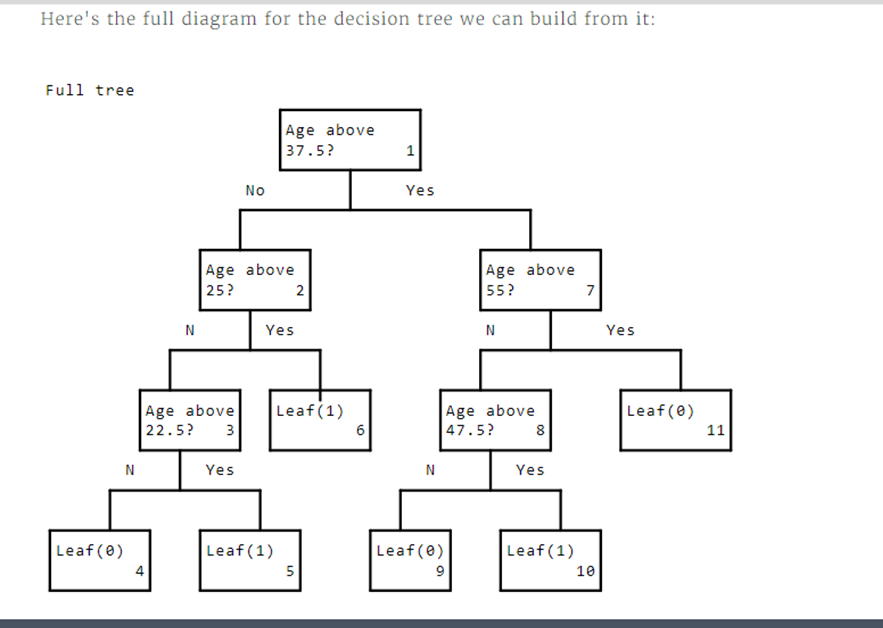

This tree predicts all of our values perfectly. It will always get a right answer on the training set, but this is equivalent to memorizing the rules of addition. While we've built our tree in such a way that it can perfectly predict the training set, the way it's constructed doesn't make sense when we take a step back.

That's because the tree above is saying that:

- If you're under 22.5 years old, you have a low income
- If you're 22.5 - 37.5, you have a high income
- If you're 37.5 - 47.5, you have a low income
- If you're 47.5 to 55, you have a high income
- Finally, if you're above 55, you have a low income
These rules are very specific to the training set.

Think about the problem with a real-world lens. Does it make sense to predict that someone who's 20 has a low income, someone who's 25 has a high income, and someone who's 40 has a low income? Intuitively, we know that younger people tend to earn less, middle-aged people earn more, and people who have retired earn less.

Our tree has created so many age-based splits in an attempt to perfectly predict everyone's income that each split is effectively meaningless.

Here's a tree that matches up with our intuition better:

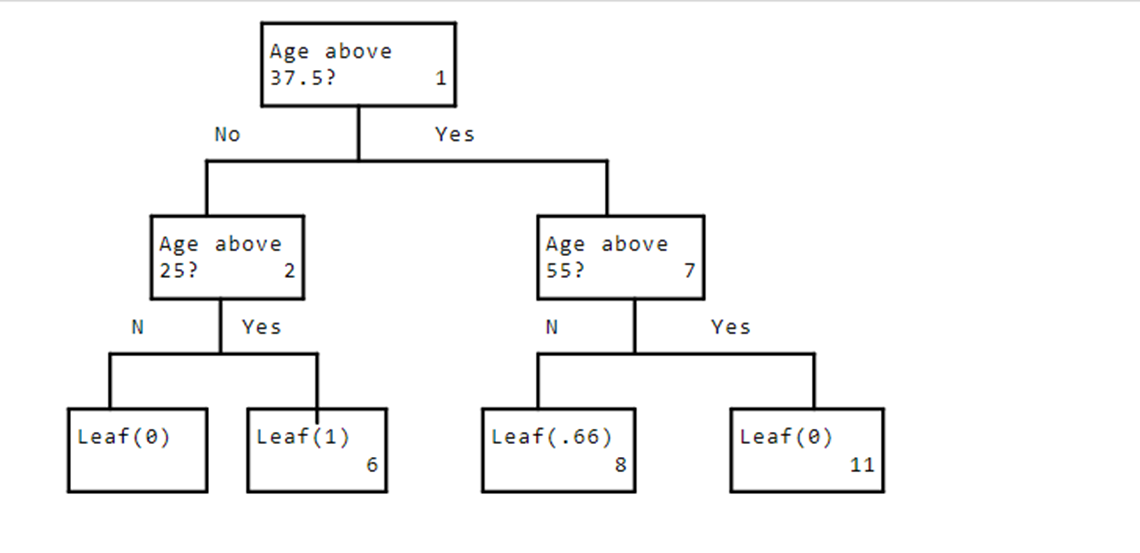

All we've done is "pruned" the tree, and removed some of the lower leaves. We've turned some of the higher-level nodes into leaves instead.

The tree above makes more intuitive sense. If you're under 25, we predict low income. If you're between 25 and 55, we predict high income (the .66 rounds up to 1). If you're above 55, we predict low income.

This version actually has lower accuracy on our training set, but will generalize to new examples better because it matches reality more closely.

Trees overfit when they have too much depth and make overly complex rules that match the training data, but aren't able to generalize well to new data. This may seem to be a strange principle at first, but the deeper a tree is, the worse it typically performs on new data.

### Reducing Overfitting with a Shallower Tree

There are three main ways to combat overfitting:

- "Prune" the tree after we build it to remove unnecessary leaves.
- Use ensembling to blend the predictions of many trees.
- Restrict the depth of the tree while we're building it.

While we'll explore all of these, we'll look at the third method first.

Limiting tree depth during the building process will result in more general rules. This prevents the tree from overfitting.

We can restrict tree depth by adding a few parameters when we initialize the DecisionTreeClassifier class:

`max_depth` - Globally restricts how deep the tree can go

`min_samples_split` - The minimum number of rows a node should have before it can be split; if this is set to 2, for example, 
then nodes with 2 rows won't be split, and will become leaves instead

`min_samples_leaf` - The minimum number of rows a leaf must have

`min_weight_fraction_leaf` - The fraction of input rows a leaf must have

`max_leaf_nodes` - The maximum number of total leaves; this will cap the count of leaf nodes as the tree is being built

Some of these parameters aren't compatible, however. For example, we can't use `max_depth` and `max_leaf_nodes` together.
Below, we will:

- Set `min_samples_split` to 13 when creating the DecisionTreeClassifier.
- Make predictions on the training set, compute the AUC, and assign it to `train_auc`.
- Make predictions on the `test set`, compute the AUC, and assign it to `test_auc`.

In [35]:
clf = DecisionTreeClassifier(min_samples_split=13, random_state=1)
clf.fit(train[columns], train["high_income"])
predictions = clf.predict(test[columns])
test_auc = roc_auc_score(test["high_income"], predictions)

train_predictions = clf.predict(train[columns])
train_auc = roc_auc_score(train["high_income"], train_predictions)

print(test_auc)
print(train_auc)

0.6995617145150872
0.8421431849275413


### Tweaking Parameters to Adjust AUC

By setting min_samples_split to 13, we managed to boost the test AUC from .694 to .700. The training set AUC decreased from .947 to .843, showing that the model we built was less overfit to the training set than before.

Below, we will:

- Set `max_depth` to `7` and `min_samples_split` to `13` when creating the DecisionTreeClassifier.
- Make predictions on the training set, compute the AUC, and assign it to `train_auc`.
- Make predictions on the test set, compute the AUC, and assign it to `test_auc`.

In [36]:
clf = DecisionTreeClassifier(random_state=1, min_samples_split=13, max_depth=7)
clf.fit(train[columns], train["high_income"])
predictions = clf.predict(test[columns])
test_auc = roc_auc_score(test["high_income"], predictions)

train_predictions = clf.predict(train[columns])
train_auc = roc_auc_score(train["high_income"], train_predictions)

print(test_auc)
print(train_auc)

0.7436344996725136
0.748037708309209


We just improved the AUC again! The test set AUC increased to .744, while the training set AUC decreased to .748. We aren't overfitting anymore because both AUC values are about the same.
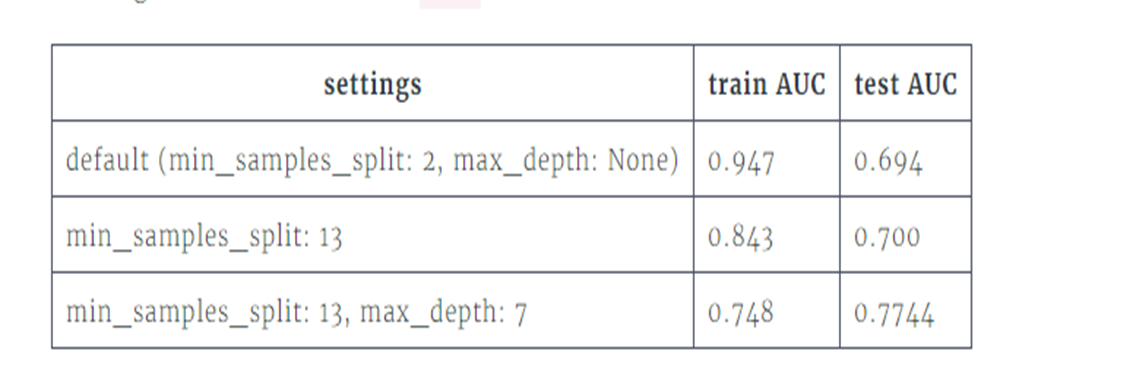

Below, we will:

- Set `max_depth` to `2` and `min_samples_split` to `100` when creating the DecisionTreeClassifier.
- Make predictions on the training set, compute the AUC, and assign it to `train_auc`.
- Make predictions on the test set, compute the AUC, and assign it to `test_auc`.

In [37]:
clf = DecisionTreeClassifier(random_state=1, min_samples_split=100, max_depth=2)
clf.fit(train[columns], train["high_income"])
predictions = clf.predict(test[columns])
test_auc = roc_auc_score(test["high_income"], predictions)

train_predictions = clf.predict(train[columns])
train_auc = roc_auc_score(train["high_income"], train_predictions)

print(test_auc)
print(train_auc)

0.6553138481876499
0.6624508042161483


### Underfitting in Simplistic Trees

Our accuracy went down in the above iteration. 

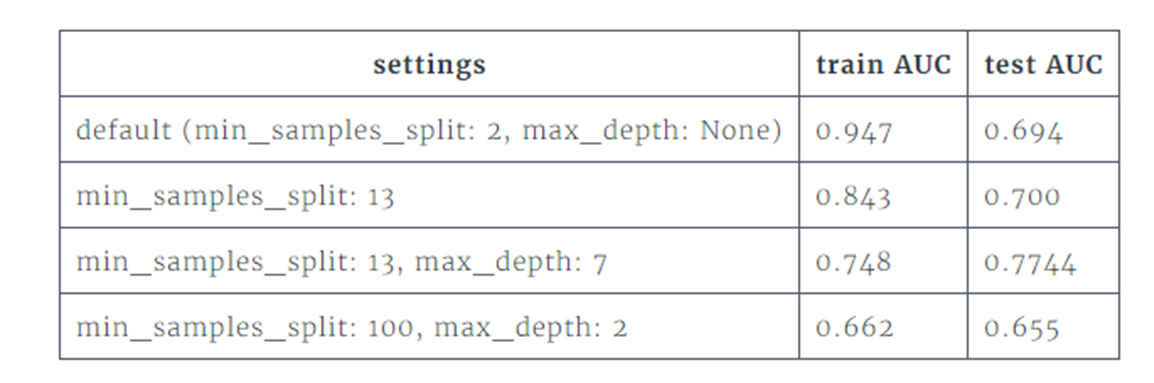

This is because we're now [underfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted). Underfitting is what occurs when our model is too simple to explain the relationships between the variables.

Let's go back to our tree diagram to explain underfitting. 

Here's the data:
```
high_income    age    marital_status
0              20     0
0              60     2
0              40     1
1              25     1
1              35     2
1              55     1
```

And here's the "right fit" tree. This tree explains the data properly, without overfitting:

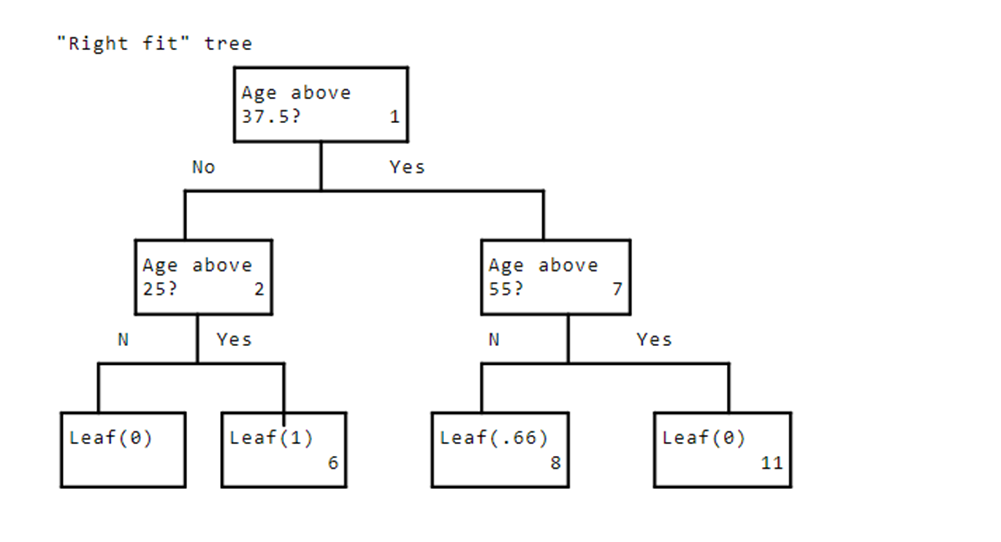

We'll trim this tree even more to show what happens when the model isn't complex enough to explain the data:
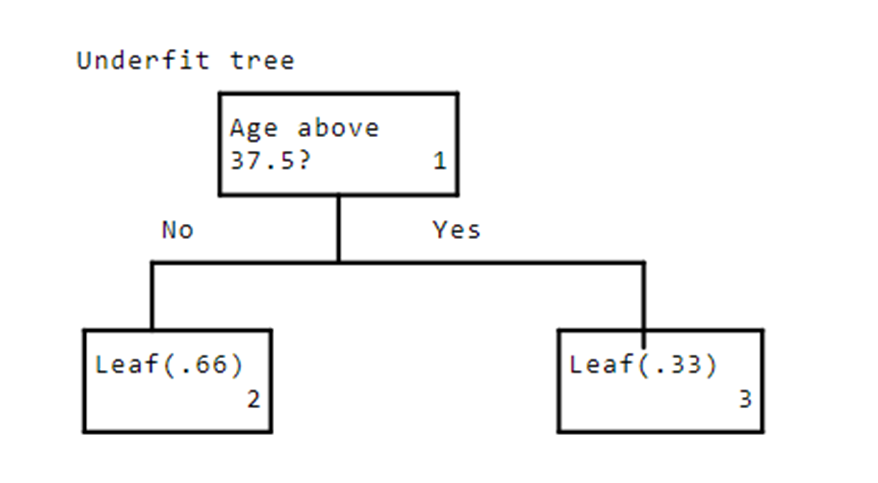

This model will predict that anyone under 37.5 has a high income (.66 rounds up), and anyone over 37.5 has a low income (.33 rounds down). It's too simple to model reality, in which people earn less while they're young, more during middle age, and less again after retirement.

Therefore, this tree underfits the data and will have lower accuracy than the appropriate version.

### The Bias-Variance Tradeoff
By artificially restricting the depth of our tree, we prevent it from creating a model that's complex enough to correctly categorize some of the rows. If we don't perform the artificial restrictions, however, the tree becomes too complex, fits quirks in the data that only exist in the training set, and doesn't generalize to new data.

This is known as the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). Imagine that we take a random sample of training data and create many models. If the models' predictions for the same row are far apart from each other, we have high variance. Imagine this time that we take a random sample of the training data and create many models. If the models' predictions for the same row are close together but far from the actual value, then we have high bias.

High bias can cause underfitting -- if a model is consistently failing to predict the correct value, it may be that it's too simple to model the data faithfully.

High variance can cause overfitting. If a model varies its predictions significantly based on small changes in the input data, then it's likely fitting itself to quirks in the training data, rather than making a generalizable model.

We call this the bias-variance tradeoff because decreasing one characteristic will usually increase the other. This is a limitation of all machine learning algorithms. If we'd like to read more about the tradeoff, check out programmer [Scott Fortmann-Roe's post](http://scott.fortmann-roe.com/docs/BiasVariance.html) on this topic.

Decision trees typically suffer from high variance. The entire structure of a decision tree can change if we make a minor alteration to its training data. By restricting the depth of the tree, we increase the bias and decrease the variance. If we restrict the depth too much, we increase bias to the point where it will underfit.

We'll generally need to use our intuition and manually tweak parameters to get the "right" fit.


### Exploring Decision Tree Variance

We can induce variance and see what happens with a decision tree. To introduce noise into the data, we'll add a column of random values. A model with high variance (like a decision tree) will pick up on this noise, and overfit to it. This is because models with high variance are very sensitive to small changes in input data.

In [38]:
np.random.seed(1)

# Generate a column containing random numbers from 0 to 4
income["noise"] = np.random.randint(4, size=income.shape[0])

# Adjust "columns" to include the noise column
columns = ["noise", "age", "workclass", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "hours_per_week", "native_country"]

# Make new train and test sets
train_max_row = math.floor(income.shape[0] * .8)
train = income.iloc[:train_max_row]
test = income.iloc[train_max_row:]

# Initialize the classifier
clf = DecisionTreeClassifier(random_state=1)
clf.fit(train[columns], train["high_income"])
predictions = clf.predict(test[columns])
test_auc = roc_auc_score(test["high_income"], predictions)

train_predictions = clf.predict(train[columns])
train_auc = roc_auc_score(train["high_income"], train_predictions)

print(test_auc)
print(train_auc)

0.6914060013941348
0.9750761614350801


### Pruning Leaves to Prevent Overfitting

As we can see above, the random noise column causes significant overfitting. Our test set accuracy decreases to `.691`, and our training set accuracy increases to `.975`. One way to prevent overfitting is to block the tree from growing beyond a certain depth (we tried this before). Another technique is called [pruning](https://en.wikipedia.org/wiki/Decision_tree_pruning). Pruning involves building a full tree, and then removing the leaves that don't add to prediction accuracy. Pruning prevents a model from becoming overly complex. It can result in a simpler model that has higher accuracy on the testing set.

Data scientists use pruning less often than parameter optimization (what we just did) and ensembling. It's still an important technique, though. 

### Knowing when to use Decision Trees

Let's go over the main advantages and disadvantages of using decision trees. The main advantages of using decision trees is that they're:

Easy to interpret
Relatively fast to fit and make predictions
Able to handle multiple types of data
Able to pick up nonlinearities in data, and usually fairly accurate
The main disadvantage of using decision trees is their tendency to overfit.

Decision trees are a good choice for tasks where it's important to be able to interpret and convey why the algorithm is doing what it's doing.

The most powerful way to reduce decision tree overfitting is to create ensembles of trees. The [random forest algorithm](https://en.wikipedia.org/wiki/Random_forest) is a popular choice for doing this. In cases where prediction accuracy is the most important consideration, random forests usually perform better.

In the next section, we'll explore the random forest algorithm in greater depth.

## Sec-IV: Random Forests

### Combining Model Predictions with Ensembles
Above, we learned about decision trees, and looked at ways to reduce overfitting. The most powerful tool for reducing decision tree overfitting is called the random forest algorithm. In this section, we'll learn how to construct and apply random forests.

A random forest is a kind of [ensemble](https://en.wikipedia.org/wiki/Ensemble_learning) model. Ensembles combine the predictions of multiple models to create a more accurate final prediction. We'll make a simple ensemble to see how they work.

We'll create two decision trees with slightly different parameters:

- One with `min_samples_leaf` set to 2
- One with `max_depth` set to 5
Then, we'll check their accuracies separately. After that, we'll combine their predictions and compare the combined accuracy with the individual accuracies of both trees.

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

columns = ["age", "workclass", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "hours_per_week", "native_country"]

clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2)
clf.fit(train[columns], train["high_income"])

clf2 = DecisionTreeClassifier(random_state=1, max_depth=5)
clf2.fit(train[columns], train["high_income"])

predictions = clf.predict(test[columns])
print(roc_auc_score(test["high_income"], predictions))

predictions = clf2.predict(test[columns])
print(roc_auc_score(test["high_income"], predictions))

0.6878964226062301
0.6759853906508785


### Combining Predictions
When we have multiple classifiers making predictions, we can treat each set of predictions as a column in a matrix. Here's an example where we have Decision Tree 1 (`DT1`), Decision Tree 2 (`DT2`), and Decision Tree 3 (`DT3`):

```
DT1     DT2    DT3
0       1      0
1       1      1
0       0      1
1       0      0
```

Whenever we add more models to our ensemble, we just add more columns to the combined predictions. Ultimately, we don't want this matrix, though -- we want one prediction per row in the training data. To accomplish this, we'll need to create rules to convert each row of our matrix of predictions into a single number.

We want to create a `Final Prediction` vector that looks like this:

```
DT1     DT2    DT3    Final Prediction
0       1      0      0
1       1      1      1
0       0      1      0
1       0      0      0
```
There are many ways to get from the output of multiple models to a final vector of predictions. One method is majority voting, in which each classifier gets a "vote," and the most commonly voted value for each row "wins." This only works if there are more than two classifiers (and ideally an odd number, so we don't have to write a rule to break ties). Majority voting is what we applied in the example above.

Because we only had two classifiers on the last cell, we'll have to use a different method to combine predictions. We'll take the mean of all of the items in a row. Right now, we're using the `predict()` method, which returns either `0` or `1`. `predict()` returns something like this:

```
0
1
0
1
```
We can use the [`DecisionTreeClassifier.predict_proba` method](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba) instead, which will predict a probability from `0` to `1` that a given class is the right one for a row. Because `0` and `1` are our two classes, we'll get a matrix containing the number of rows in the income dataframe, and two columns. `predict_proba()` will return a result that looks like this:

```
0     1
.7    .3
.2    .8
.1    .9
```
Each row will correspond to a prediction. The first column is the probability that the prediction is a `0`, and the second column is the probability that the prediction is a `1`. Each row adds up to `1`.

If we just take the second column, we get the average value that the classifier would predict for that row. If there's a `.9` probability that the correct classification is `1`, we can use the `.9` as the value the classifier is predicting. This will give us a continuous output in a single vector, instead of just `0` or `1`.

Then we can add together all of the vectors we get through this method, and divide the sum by the total number of vectors to get the mean prediction made across the entire ensemble for a particular row. Finally, we round off to get a `0` or `1` prediction for the row.

If we use the `predict_proba()` method on both classifiers from the last screen to generate probabilities, take the mean for each row, and then round the results, we'll get ensemble predictions.

Below, we will:
Add `predictions` and `predictions2`, then divide by 2 to get the mean.
Use `numpy.round()` to round all of the resulting predictions.
Print the resulting `AUC` score between the actual values and the predictions.

In [40]:
predictions = clf.predict_proba(test[columns])[:,1]
predictions2 = clf2.predict_proba(test[columns])[:,1]

combined = (predictions + predictions2) / 2
rounded = np.round(combined)

print(roc_auc_score(test["high_income"], rounded))

0.7150846804038882


### Why Ensembling Works

As we can see, the combined predictions of the two trees had a higher AUC than that of either tree on its own:
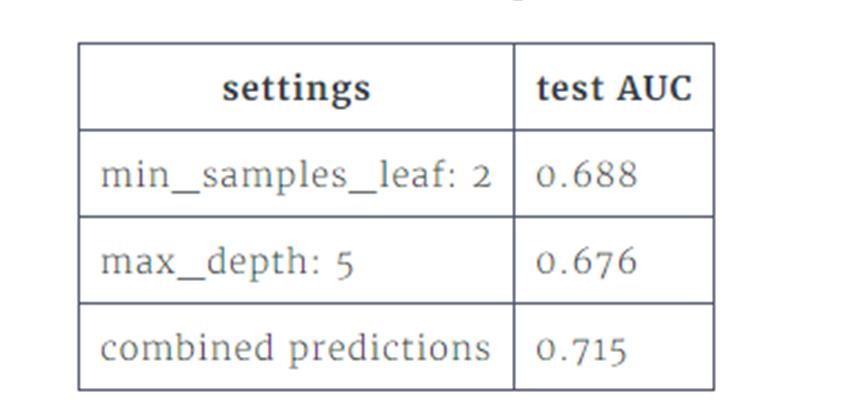

To intuitively understand why this makes sense, think about two people with the same level of talent. One learned programming in college, while the other learned it on her own (let's say using Dataquest!).

If we give both of them the same project, they'll approach it in slightly different ways, due to their different experiences. They may both produce code that achieves the same result, but one may run faster in certain areas. The other may have a better interface. Even though both of them have about the same level of talent, their solutions are stronger in different areas because they approached the problem differently.

If we combine the best parts of both of their projects, we'll end up with a stronger combined project.

Ensembling is exactly the same. The models are approaching the same problem in slightly different ways, and building different trees because we used different parameters for each one. Each tree makes different predictions in different areas. Even though both trees have about the same accuracy, when we combine them, the result is stronger because it leverages the strengths of both approaches.

The more "diverse" or dissimilar the models we use to construct an ensemble are, the stronger their combined predictions will be (assuming that all of the models have about the same accuracy). Ensembling a decision tree and a logistic regression model, for example, will result in stronger predictions than ensembling two decision trees with similar parameters. That's because those two models use very different approaches to arrive at their answers.

On the other hand, if the models we ensemble are very similar in how they make predictions, ensembling will result in a negligible boost.

Ensembling models with very different accuracies generally won't improve overall accuracy. Ensembling a model with a .75 AUC and a model with a .85 AUC on a test set will usually result in an AUC somewhere in between the two original values. There's a way around this that we'll discuss later on, which we call weighting.

### Introducing Variation with Bagging

A random forest is an ensemble of decision trees. If we don't make any modifications to the trees, each tree will be exactly the same, so we'll get no boost when we ensemble them. In order to make ensembling effective, we have to introduce variation into each individual decision tree model.

If we introduce variation, each tree will be be constructed slightly differently, and will therefore make different predictions. This variation is what puts the "random" in "random forest."There are two main ways to introduce variation in a random forest -- bagging and random feature subsets. We'll consider into bagging first.
In a random forest, we don't train each tree on the entire data set. We train it on a random sample of the data, or a "bag," instead. We perform this sampling with replacement, which means that after we select a row from the data we're sampling, we put the row back in the data so it can be picked again. Some rows from the original data may appear in the "bag" multiple times.

Below, we will:

- `predictions` is a list of vectors corresponding to predictions on the test set.
- Use the technique we employed earlier to add all of the vectors together, and divide by 10 to get the mean prediction for each row.
- Use numpy.round() to round the resulting predictions.
- Finally, print the AUC score between the combined predictions and `test["high_income"]`.

In [41]:
# We'll build 10 trees
tree_count = 10

# Each "bag" will have 60% of the number of original rows
bag_proportion = .6

predictions = []
for i in range(tree_count):
    # We select 60% of the rows from train, sampling with replacement
    # We set a random state to ensure we'll be able to replicate our results
    # We set it to i instead of a fixed value so we don't get the same sample in every loop
    # That would make all of our trees the same
    bag = train.sample(frac=bag_proportion, replace=True, random_state=i)
    
    # Fit a decision tree model to the "bag"
    clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2)
    clf.fit(bag[columns], bag["high_income"])
    
    # Using the model, make predictions on the test data
    predictions.append(clf.predict_proba(test[columns])[:,1])
combined = np.sum(predictions, axis=0) / 10
rounded = np.round(combined)

print(roc_auc_score(test["high_income"], rounded))


0.7329963297474371


### Selecting Random Features
Using the bagging example from above, we gained some accuracy over a single decision tree. To be exact, we achieved an AUC score of around .733 with bagging, which is an improvement over the AUC score of .688 we got without bagging:
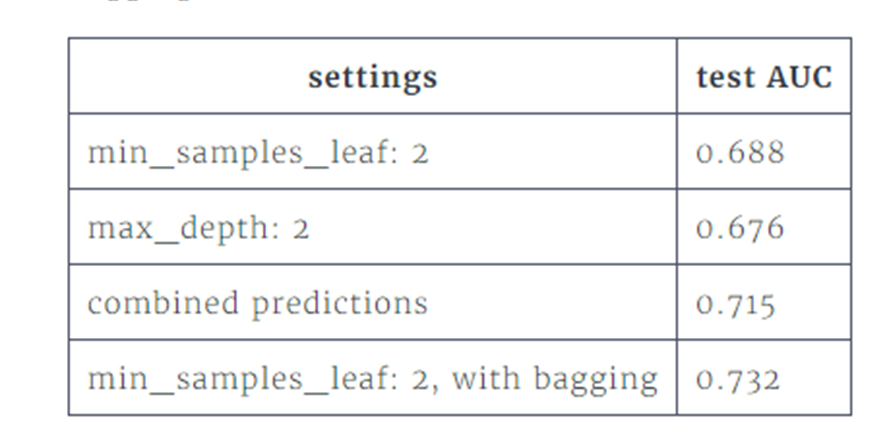

Going back to the decision tree algorithm we explored earlier to explain random feature subsets:

- First we pick the maximum number of features we want to evaluate each time we split the tree.
 - This has to be less than the total number of columns in the data.
- Every time we split, we pick a random sample of features from the data.
- Then we compute the information gain for each feature in our random sample, and pick the one with the highest information gain to split on.

To understand how splits work, let's look at information gain or entropy. Entropy is the measure of "disorder" in the data set. If a dataset has all the same labels, they'll have low entropy. If all the labels are different, they'll have high entropy. Splits that give us more information about the data, will ideally minimize entropy. In other words, the tree will ideally split the labels into distinct groups with as little mixture possible. This'll allow the splits to give our tree more predictive power.

We're repeating the same process to select the optimal split that minimizes entropy for a node. However, we'll only evaluate a constrained set of features that we select randomly. This introduces variation into the trees, and makes for more powerful ensembles.

Below is the ID3 algorithm that we developed earlier. We'll modify it to only consider a certain subset of the features. 

We will:
- First modify `find_best_column` to select a random sample from columns before computing information gain.

 - Each subset will have 2 items in it.
 - We can use `numpy.random.choice()` to select a random sample.
 - The first input is the list we're picking from, and the second is the number of items we want to pick.
We should be careful not to overwrite columns when we do the selection.

= The random sample should go in a different variable.
Use the `print()` function to display tree.

In [42]:
data = pd.DataFrame([
    [0,4,20,0],
    [0,4,60,2],
    [0,5,40,1],
    [1,4,25,1],
    [1,5,35,2],
    [1,5,55,1]
    ])
data.columns = ["high_income", "employment", "age", "marital_status"]

In [43]:
# Set a random seed to make the results reproducible
np.random.seed(1)

# The dictionary to store our tree
tree = {}
nodes = []

# The function to find the column to split on
def find_best_column(data, target_name, columns):
    information_gains = []
    
    # Select two columns randomly
    cols = np.random.choice(columns, 2)
    
    for col in cols:
        information_gain = calc_information_gain(data, col, "high_income")
        information_gains.append(information_gain)

    highest_gain_index = information_gains.index(max(information_gains))
    
    # Get the highest gain by indexing "cols"
    highest_gain = cols[highest_gain_index]
    
    return highest_gain

In [44]:
# The function to construct an ID3 decision tree
def id3(data, target, columns, tree):
    unique_targets = pd.unique(data[target])
    nodes.append(len(nodes) + 1)
    tree["number"] = nodes[-1]

    if len(unique_targets) == 1:
        if 0 in unique_targets:
            tree["label"] = 0
        elif 1 in unique_targets:
            tree["label"] = 1
        return
    
    best_column = find_best_column(data, target, columns)
    column_median = data[best_column].median()
    
    tree["column"] = best_column
    tree["median"] = column_median
    
    left_split = data[data[best_column] <= column_median]
    right_split = data[data[best_column] > column_median]
    split_dict = [["left", left_split], ["right", right_split]]
    
    for name, split in split_dict:
        tree[name] = {}
        id3(split, target, columns, tree[name])

In [45]:
# Run the ID3 algorithm on our data set and print the resulting tree
id3(data, "high_income", ["employment", "age", "marital_status"], tree)
print(tree)

{'number': 1, 'column': 'age', 'median': 37.5, 'left': {'number': 2, 'column': 'employment', 'median': 4.0, 'left': {'number': 3, 'column': 'age', 'median': 22.5, 'left': {'number': 4, 'label': 0}, 'right': {'number': 5, 'label': 1}}, 'right': {'number': 6, 'label': 1}}, 'right': {'number': 7, 'column': 'age', 'median': 55.0, 'left': {'number': 8, 'column': 'age', 'median': 47.5, 'left': {'number': 9, 'label': 0}, 'right': {'number': 10, 'label': 1}}, 'right': {'number': 11, 'label': 0}}}


### Random Subsets in scikit-learn

We can also repeat our random subset selection process in scikit-learn. We just set the `splitter` parameter on DecisionTreeClassifier to "random", and the `max_features` parameter to "auto". If we have N columns, this will pick a subset of features of size 
$√N$
, compute the Gini coefficient for each (this is similar to information gain), and split the node on the best column in the subset.

Below, we will:
- Modify the instantiation of the DecisionTreeClassifier object.

- Set `splitter` to "random", and `max_features` to "auto".
Print the resulting AUC score.

In [46]:
# We'll build 10 trees
tree_count = 10

# Each "bag" will have 60% of the number of original rows
bag_proportion = .6

predictions = []
for i in range(tree_count):
    # We select 60% of the rows from train, sampling with replacement
    # We set a random state to ensure we'll be able to replicate our results
    # We set it to i instead of a fixed value so we don't get the same sample every time
    bag = train.sample(frac=bag_proportion, replace=True, random_state=i)
    
    # Fit a decision tree model to the "bag"
    
    clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2, splitter="random", max_features="auto")
    clf.fit(bag[columns], bag["high_income"])
    
    # Using the model, make predictions on the test data
    predictions.append(clf.predict_proba(test[columns])[:,1])

combined = np.sum(predictions, axis=0) / 10
rounded = np.round(combined)

print(roc_auc_score(test["high_income"], rounded))

0.7345958637997538


### Putting it all Together - Random Forest Classifier
Using random subsets improved the accuracy over using bagging alone:

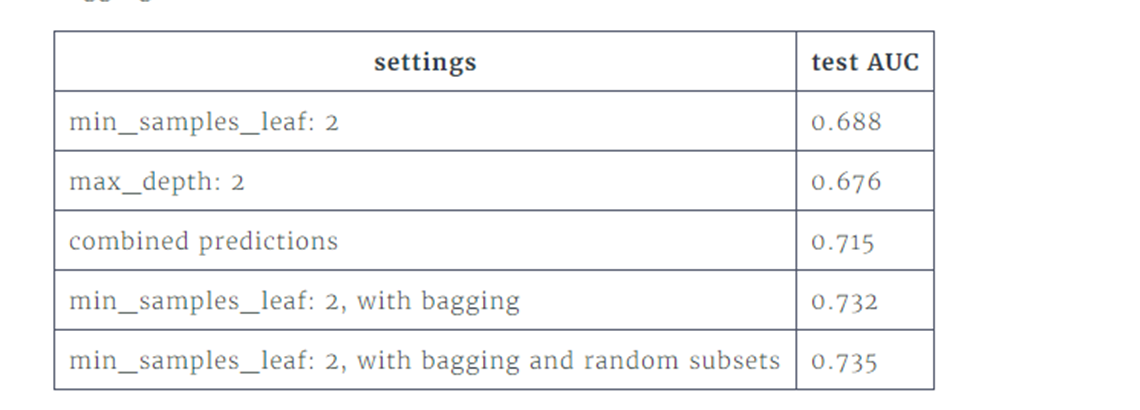

So far, we've demonstrated the two building blocks of random forests, bagging and random feature subsets. Luckily, we don't have to write code from scratch each time. Scikit-learn has a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class and a [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) class that enable us to train and test random forest models quickly.

When we instantiate a `RandomForestClassifier`, we pass in an `n_estimators` parameter that indicates how many trees to build. While adding more trees usually improves accuracy, it also increases the overall time the model takes to train.

`RandomForestClassifier` has a similar interface to `DecisionTreeClassifier`, and we can use the `fit()` and `predict()` methods to train and make predictions.

Below, we will:
- Instantiate a random forest object `clf`
- Fit `clf` to the training data and make predictions on the test data.
- Compute and print the AUC score between the test predictions and the actual values.

In [47]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=5, random_state=1, min_samples_leaf=2)
clf.fit(train[columns], train["high_income"])
predictions = clf.predict(test[columns])
print(roc_auc_score(test["high_income"], predictions))

0.7347461391939776


### Tweaking Parameters to Increase Accuracy

Similar to decision trees, we can tweak some of the parameters for random forests, including:

- `min_samples_leaf`
- `min_samples_split`
- `max_depth`
- `max_leaf_nodes`

These parameters apply to the individual trees in the model, and change how they are constructed. There are also parameters specific to the random forest that alter its overall construction:

- `n_estimators`
- `bootstrap` - "Bootstrap aggregation" is another name for bagging; this parameter indicates whether to turn it on (Defaults to True)

Tweaking parameters can increase the accuracy of the forest. The easiest tweak is to increase the number of estimators we use. This approach yields diminishing returns -- going from `10` trees to `100` will make a bigger difference than going from `100` to `500`, which will make a bigger difference than going from `500` to `1000`. The accuracy increase function is logarithmic, so increasing the number of trees beyond a certain number (usually `200`) won't help much at all.

Below, we will increase n_estimators to `150`

In [48]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=150, random_state=1, min_samples_leaf=2)

clf.fit(train[columns], train["high_income"])

predictions = clf.predict(test[columns])
print(roc_auc_score(test["high_income"], predictions))

0.7379403213124711


### Reducing Overfitting
We were able to improve the AUC from `0.735` to `0.738`, but the model using `150` trees took much longer to train. While the extra training time is trivial on the data set we're working with right now, understanding this trade-off will help us when we're working with much larger data sets where the extra time could amount to hours or days!

One of the major advantages of random forests over single decision trees is that they tend to overfit less. Although each individual decision tree in a random forest varies widely, the average of their predictions is less sensitive to the input data than a single tree is. This is because while one tree can construct an incorrect and overfit model, the average of 100 or more trees will be more likely to hone in on the signal and ignore the noise. The signal will be the same across all of the trees, whereas each tree will hone in on the noise differently. This means that the average will discard the noise and keep the signal.

Below, we've fit a single decision tree to the training set, and made predictions for both the training and testing sets. The AUC for the training set predictions is `.819`, while the AUC for the testing set is `.714`. The fact that the test AUC is much lower than the train AUC indicates that the model is overfitting.

In [49]:
clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=5)

clf.fit(train[columns], train["high_income"])

predictions = clf.predict(train[columns])
print(roc_auc_score(train["high_income"], predictions))

predictions = clf.predict(test[columns])
print(roc_auc_score(test["high_income"], predictions))

0.8192570489534683
0.7139325899284541


Now, for comparison between approaches with regards to overfitting, we will use RandomForestClassifier with n_estimators = 150:
- Fit `clf` to the training set and use it to make predictions on the training set.
- Then, use it to make predictions on the testing set.
- Print both AUC scores.

In [50]:
clf = RandomForestClassifier(n_estimators=150, random_state=1, min_samples_leaf=5)
clf.fit(train[columns], train["high_income"])

predictions = clf.predict(train[columns])
print(roc_auc_score(train["high_income"], predictions))

predictions = clf.predict(test[columns])
print(roc_auc_score(test["high_income"], predictions))

0.7917047295143252
0.7498874343962398


### When to use Random Forests

overfitting decreased with a random forest, and accuracy went up overall.

While the random forest algorithm is incredibly powerful, it isn't applicable to all tasks. The main strengths of a random forest are:

- Very accurate predictions - Random forests achieve near state-of-the-art performance on many machine learning tasks. Along with neural networks and gradient-boosted trees, they're typically one of the top-performing algorithms.
- Resistance to overfitting - Due to their construction, random forests are fairly resistant to overfitting. We still need to set and tweak parameters like `max_depth` though.

The main weaknesses of using a random forest are:

- They're difficult to interpret - Because we're averaging the results of many trees, it can be hard to figure out why a random forest is making predictions the way it is.
- They take longer to create - Making two trees takes twice as long as making one, making three takes three times as long, and so on. Fortunately, we can exploit multicore processors to parallelize tree construction. Scikit allows us to do this through the `n_jobs` parameter on RandomForestClassifier. This is known as parallelization.

Given these trade-offs, it makes sense to use random forests in situations where accuracy is of the utmost importance; being able to interpret or explain the decisions the model is making isn't key. In cases where time is of the essence or interpretability is important, a single decision tree may be a better choice.